# Preparation

### Import libraries

In [1]:
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical computing
from datetime import datetime
from scipy.stats import trim_mean, kurtosis, skew, boxcox, yeojohnson      # For statistical analysis
from math import sqrt
import matplotlib                # For plotting and visualization
import matplotlib.pyplot as plt  
from pandas.plotting import parallel_coordinates
import seaborn as sns            # For statistical data visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# For machine learning

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna

### Import dataset

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col = 0)
df_test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col = 0)

# EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51012 entries, 76518 to 127529
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  51012 non-null  int64  
 1   Application mode                                51012 non-null  int64  
 2   Application order                               51012 non-null  int64  
 3   Course                                          51012 non-null  int64  
 4   Daytime/evening attendance                      51012 non-null  int64  
 5   Previous qualification                          51012 non-null  int64  
 6   Previous qualification (grade)                  51012 non-null  float64
 7   Nacionality                                     51012 non-null  int64  
 8   Mother's qualification                          51012 non-null  int64  
 9   Father's qualification                 

**Observations:**

* Train dataset has 76,518 rows x 38 columns, of which 36 predictors, 1 ID column and `Target` obviously the target of the model.
* Test dataset has 51,012 rows x 37 columns of 36 predictors and 1 ID column.
* Both datasets are very structured and 'clean' with no missing values.
* All the predictors are numerical (float and integers). Columns with float data points are for grades and continuous. Other Integer columns numerical-coded (one-hot code) for categories.
* The `Target` of this model is **categorical** data, which will need further engineering.

In [6]:
df_train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
Marital status,76518.000000,1.111934,0.441669,1.000000,1.000000,1.000000,1.000000,6.000000
Application mode,76518.000000,16.054419,16.682337,1.000000,1.000000,17.000000,39.000000,53.000000
Application order,76518.000000,1.644410,1.229645,0.000000,1.000000,1.000000,2.000000,9.000000
Course,76518.000000,9001.286377,1803.438531,33.000000,9119.000000,9254.000000,9670.000000,9991.000000
Daytime/evening attendance,76518.000000,0.915314,0.278416,0.000000,1.000000,1.000000,1.000000,1.000000
Previous qualification,76518.000000,3.658760,8.623774,1.000000,1.000000,1.000000,1.000000,43.000000
Previous qualification (grade),76518.000000,132.378766,10.995328,95.000000,125.000000,133.100000,140.000000,190.000000
Nacionality,76518.000000,1.226600,3.392183,1.000000,1.000000,1.000000,1.000000,109.000000
Mother's qualification,76518.000000,19.837633,15.399456,1.000000,1.000000,19.000000,37.000000,44.000000
Father's qualification,76518.000000,23.425076,14.921164,1.000000,4.000000,19.000000,37.000000,44.000000


# Visualization
## Univariate Analysis

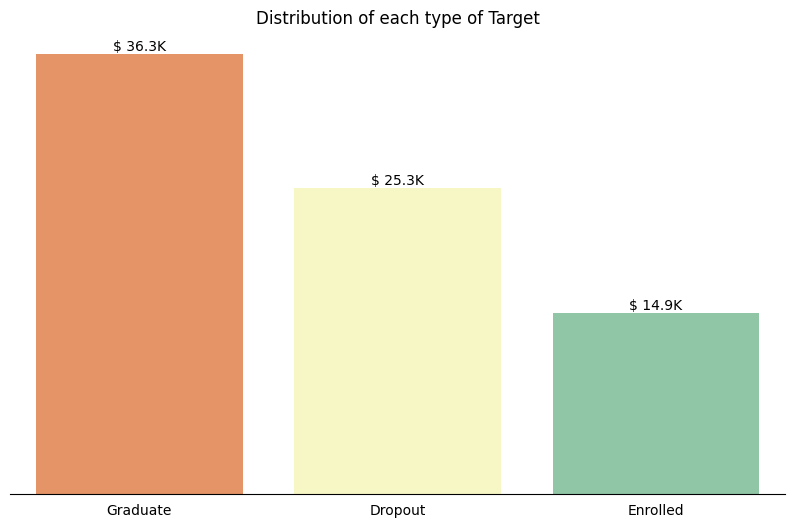

In [7]:
fig, ax = plt.subplots(figsize = (10,6))
sns.light_palette("seagreen", as_cmap=True)

ax = sns.countplot(data = df_train,
             x = 'Target',
             palette = "Spectral")
ax.set_title('Distribution of each type of Target')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.tick_params(left = False, bottom = False)

ax.bar_label(ax.containers[0], 
             labels = ['$ {:.1f}K'.format(value / 1000) for value in df_train['Target'].value_counts()],
             label_type = 'edge',
             color = 'black',
             fontsize = 10)

sns.despine(left = True, top = True)

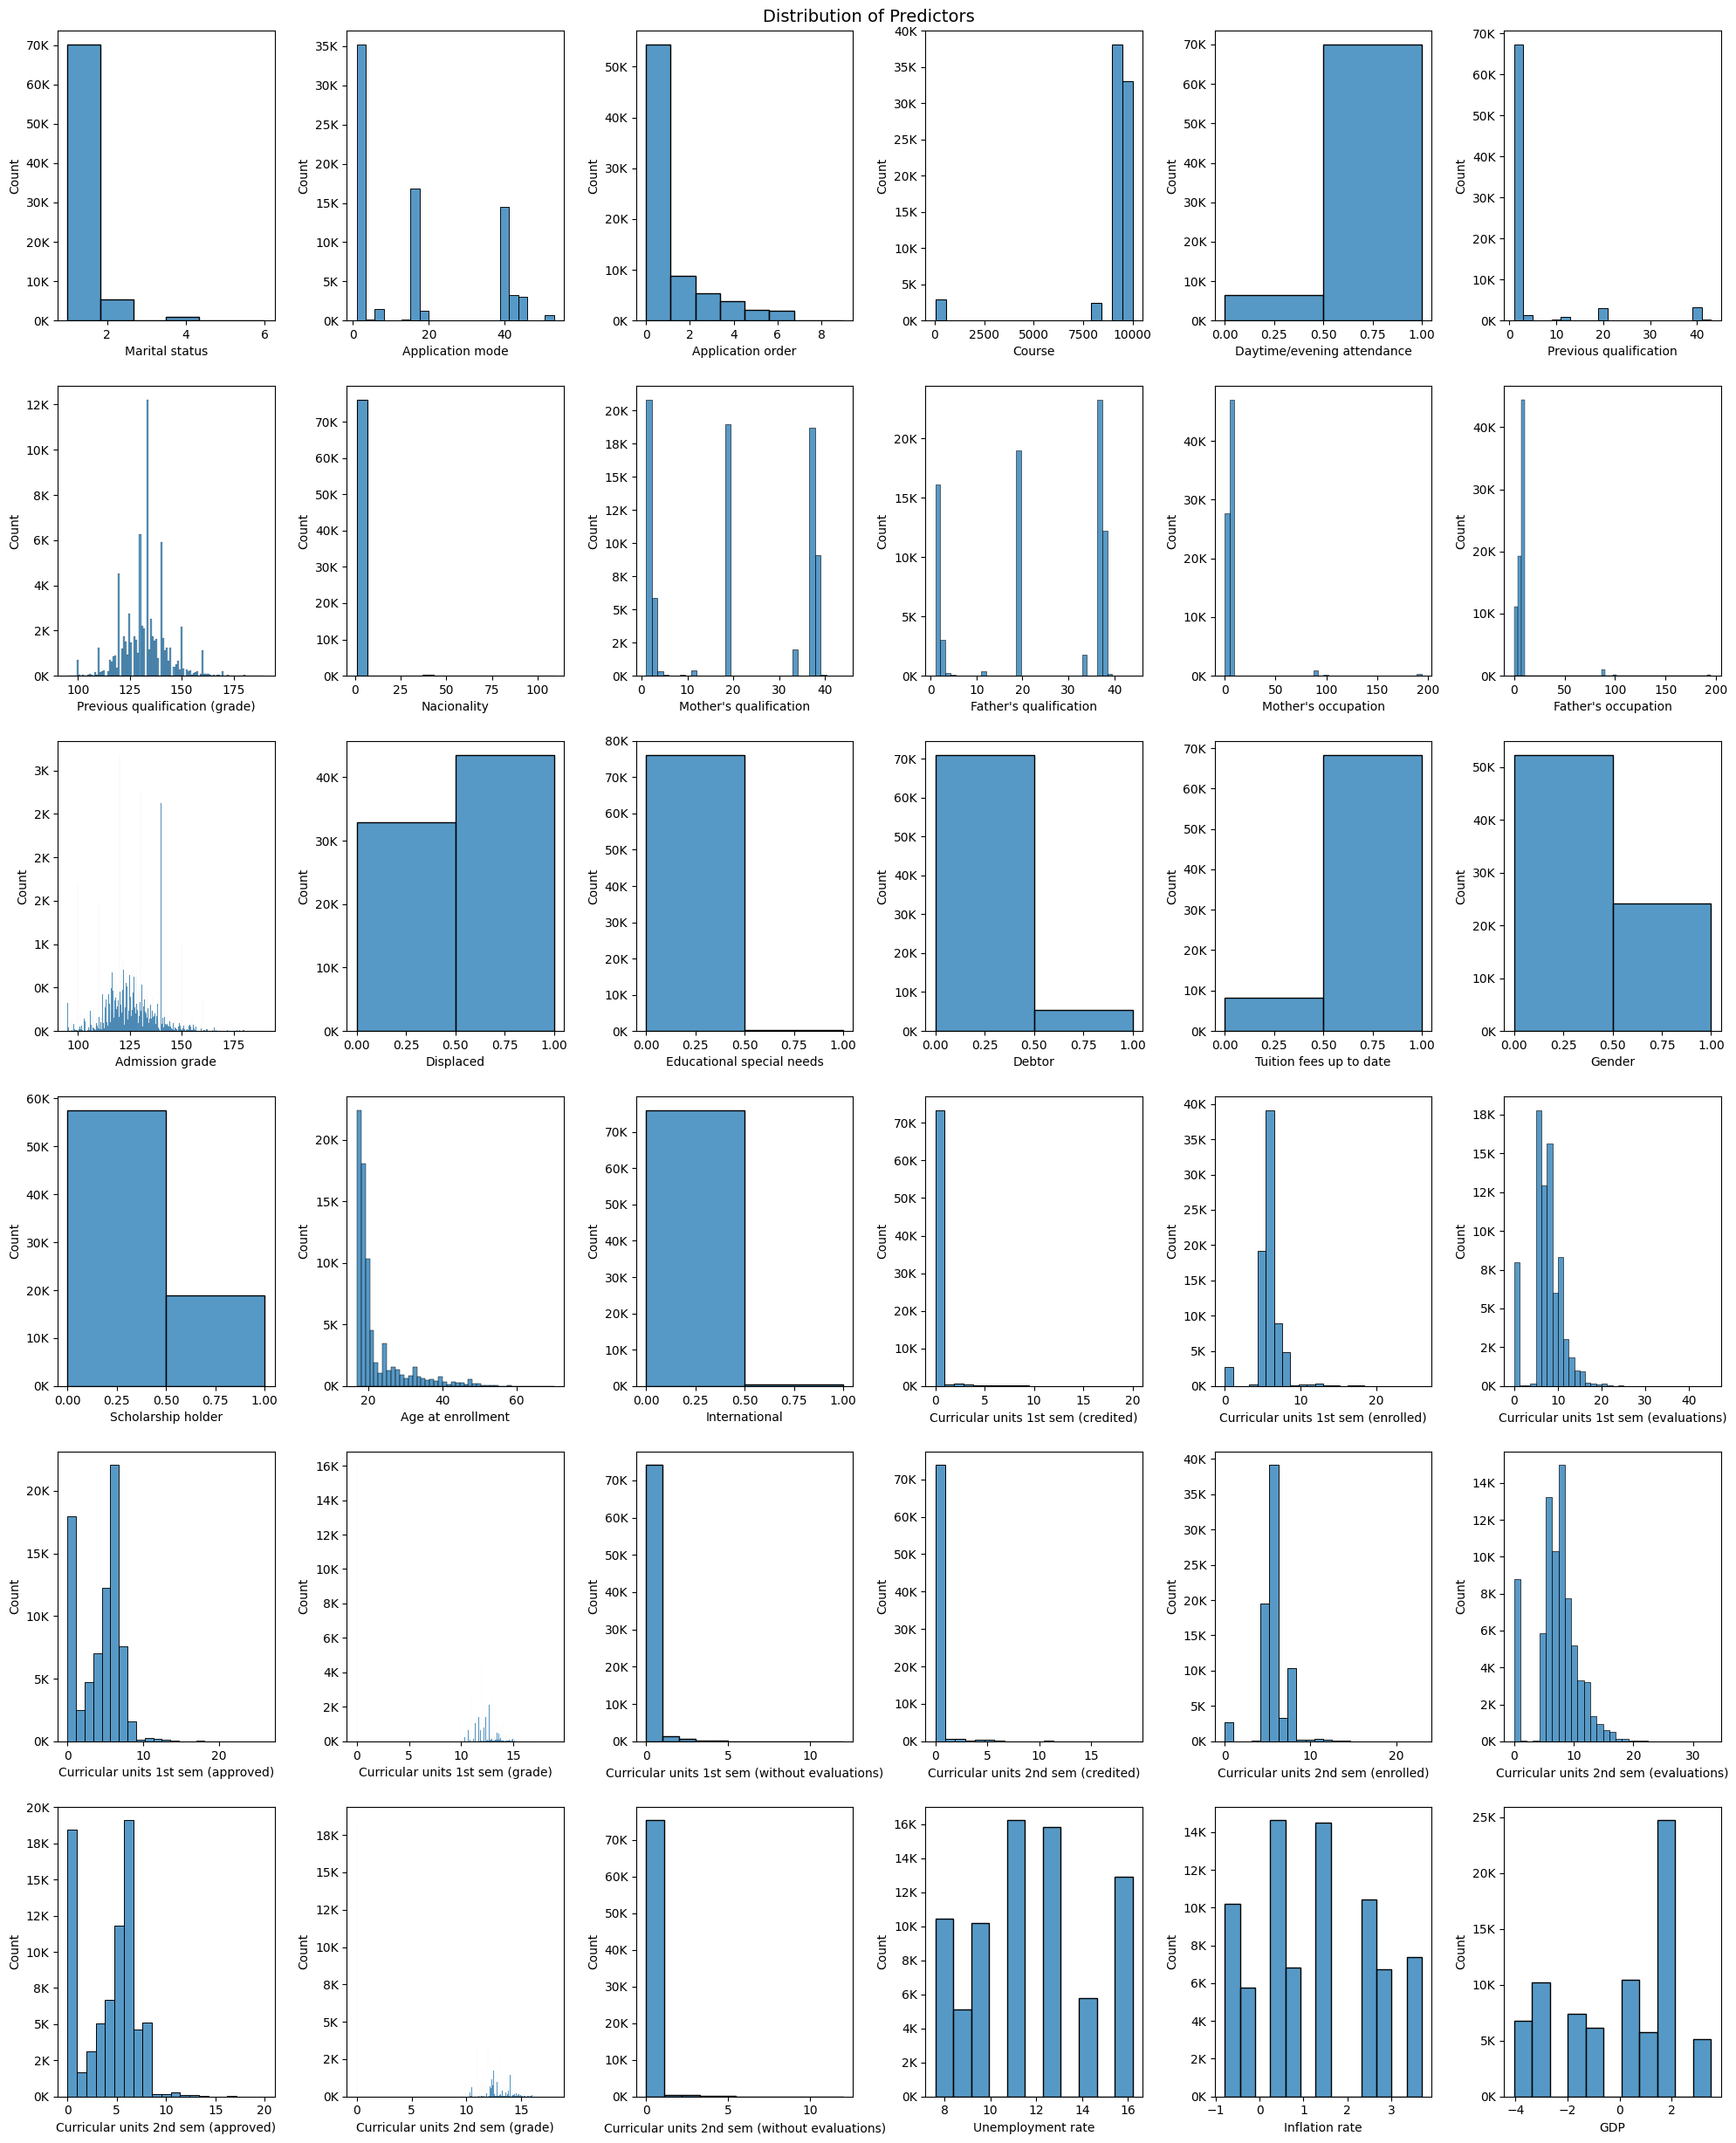

In [8]:
fig, axes = plt.subplots(6, 6, figsize=(20, 25))
 
for i, column in enumerate(df_train.columns):
    if column == 'Target':
        continue
    plt.subplots_adjust(top = 0.85)
    ax = sns.histplot(data = df_train, 
                x = column, 
                bins = df_train[column].nunique(),
                ax = axes[i // 6, i % 6])
    
    ax.set_yticklabels(['{:,.0f}K'.format(ticks / 1000) for ticks in ax.get_yticks()])
fig.tight_layout(h_pad = 2)
plt.subplots_adjust(top = 0.97)
plt.suptitle('Distribution of Predictors', fontsize = 14)
plt.show()

## Multivariate Analysis

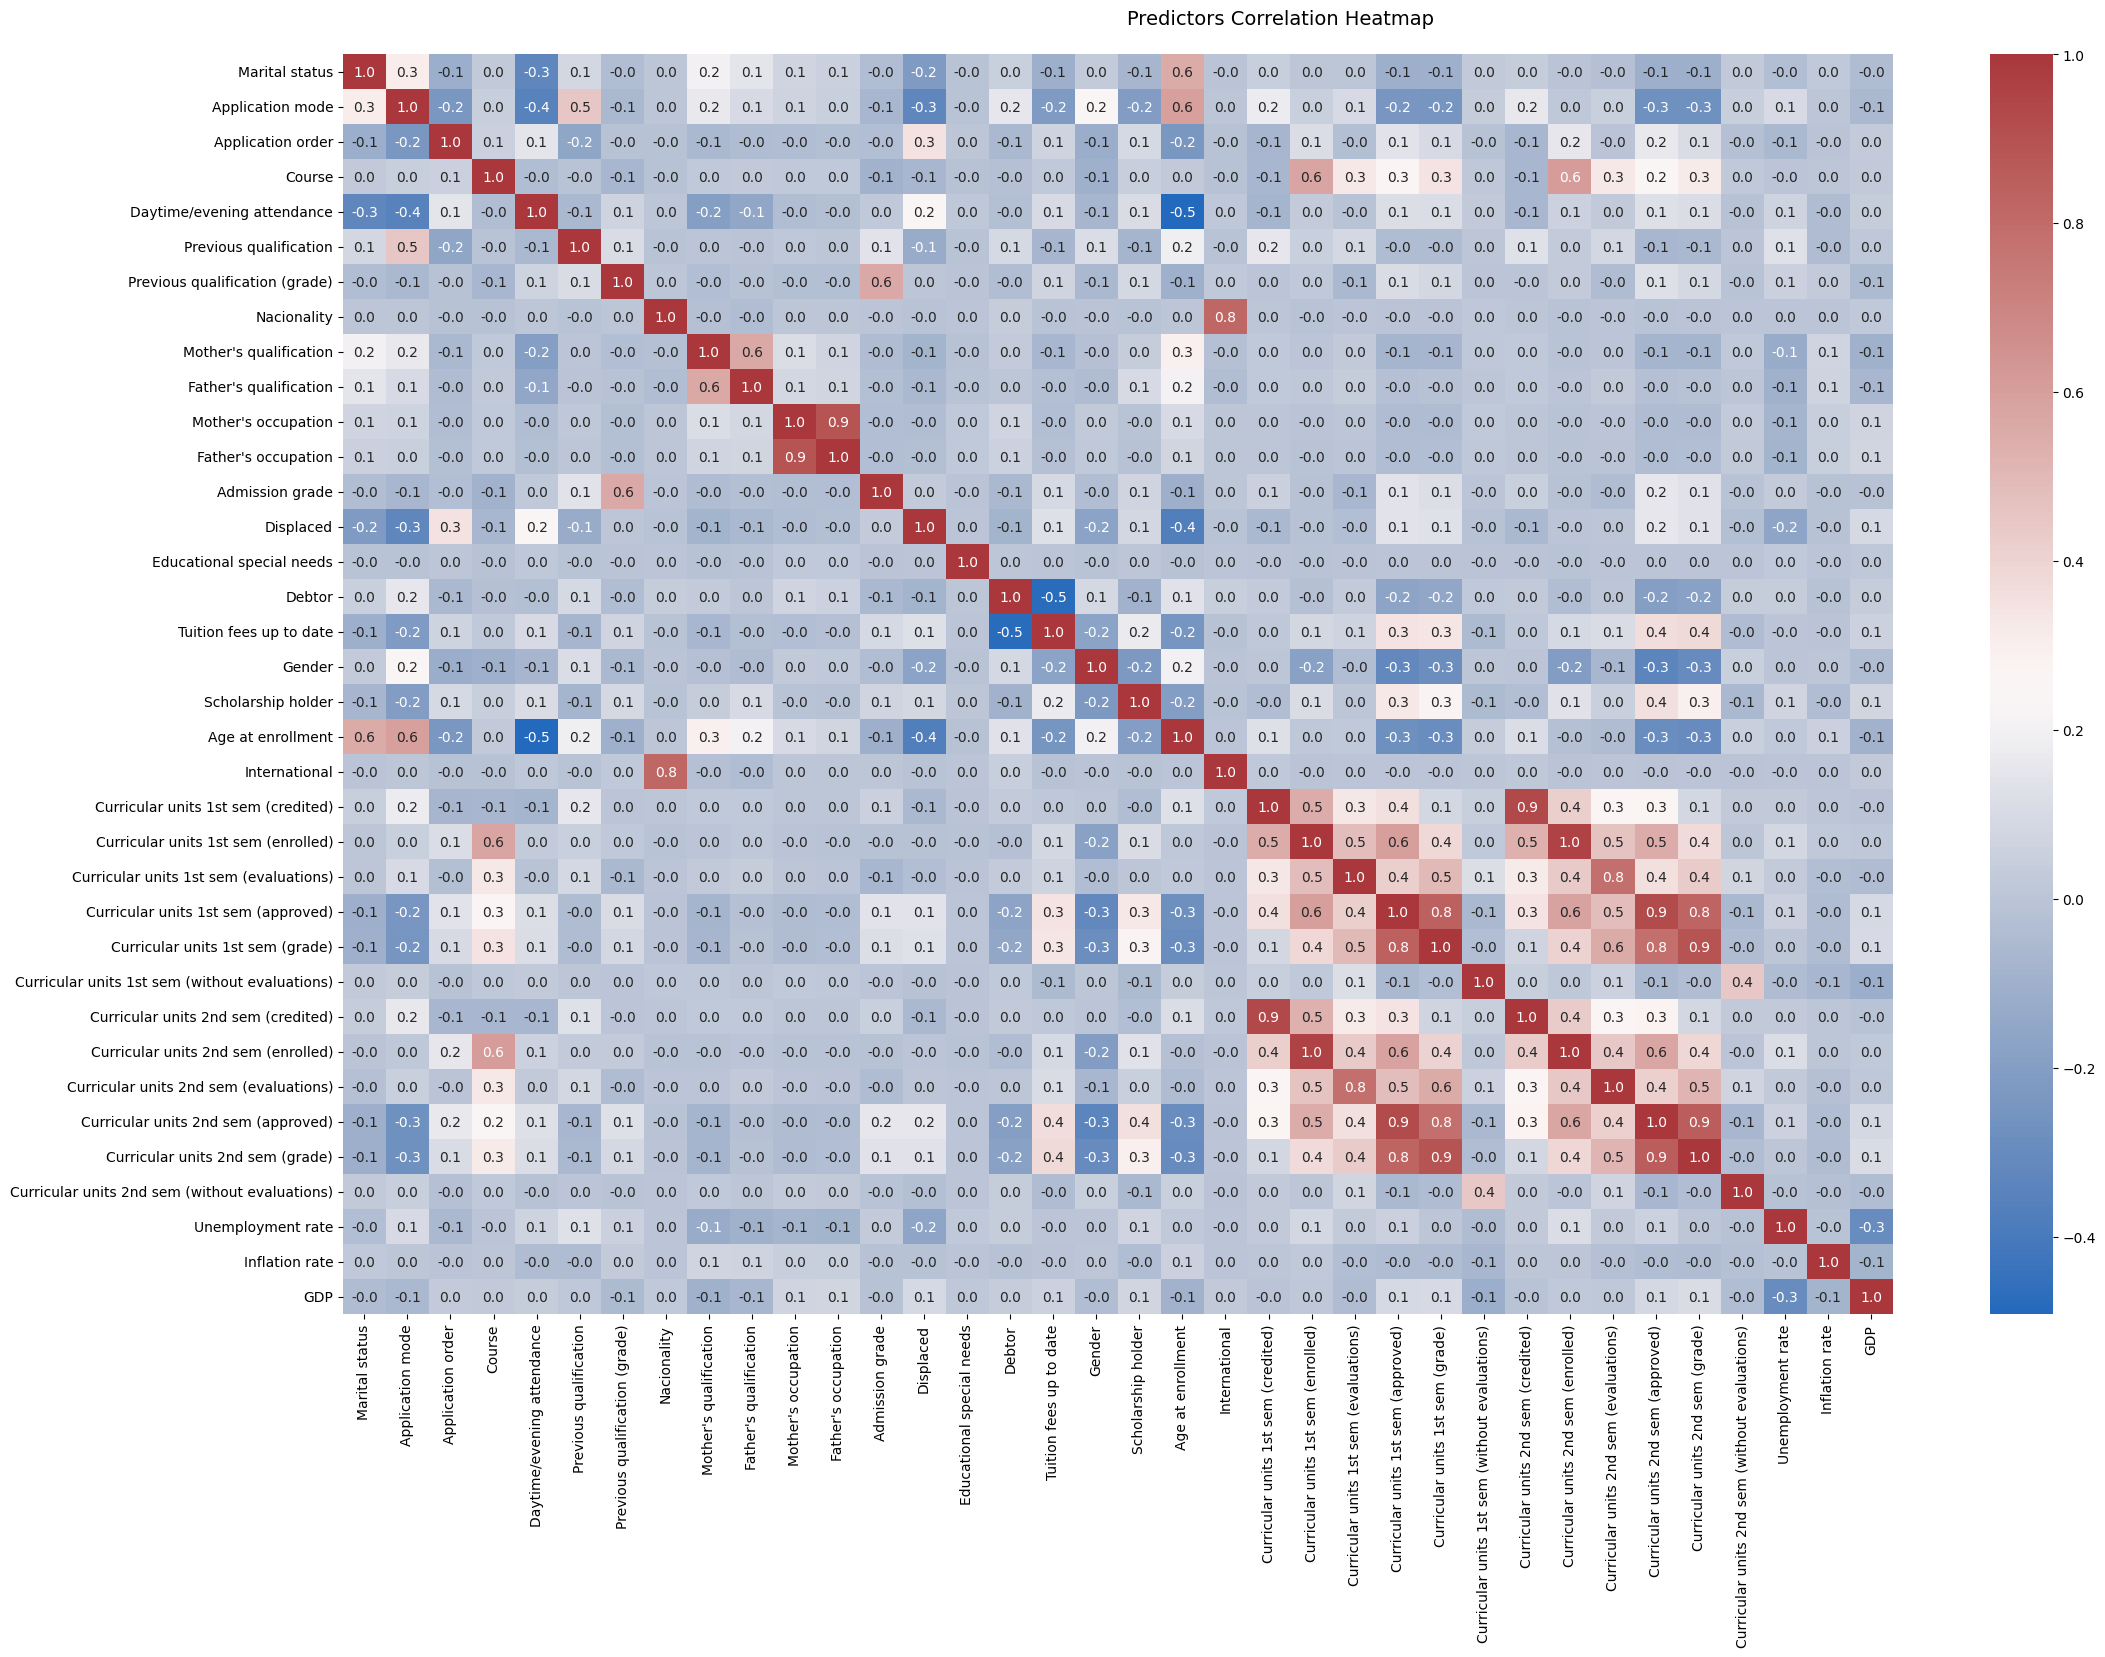

In [9]:
# Correlation Matrix Heatmap
fig, ax = plt.subplots(figsize = (25,15))
df_features = df_train.select_dtypes(include='number')
corr = df_features.corr()
hm = sns.heatmap(corr,
                annot = True,
                ax = ax,
                cmap = sns.color_palette("vlag", as_cmap = True),
                fmt = '.1f')
fig.subplots_adjust(top = 0.95)
plt.suptitle('Predictors Correlation Heatmap', fontsize = 14)
plt.show()

# Preprocessing
## Train/Test Split

In [10]:
X = df_train.drop(columns = 'Target' , axis = 1)
y = df_train['Target']

X_train , X_valid , y_train , y_valid = train_test_split(X , y , test_size = 0.2 , random_state = 42)

## Label Encoder

In [11]:
le = LabelEncoder()
# Convert the target variable 'Target' to numerical data
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)

# Feature Engineering
### Idea 1 - Create new statistic features for the grade features

In [12]:
# SCORE_FEATURES = [col for col in df_test.columns if 'Curricular' in col]

# def add_new_features(df : pd.DataFrame) -> pd.DataFrame:
#     df['total'] = df[SCORE_FEATURES].sum(axis=1)
#     df['mean'] = df[SCORE_FEATURES].mean(axis=1)
#     df['std'] = df[SCORE_FEATURES].std(axis=1)
#     df['max'] = df[SCORE_FEATURES].max(axis=1)
#     df['min'] = df[SCORE_FEATURES].min(axis=1)
#     df['median'] = df[SCORE_FEATURES].median(axis=1)
#     df['q25'] = df[SCORE_FEATURES].quantile(0.25, axis=1)
#     df['q75'] = df[SCORE_FEATURES].quantile(0.75, axis=1)
    
#     df['Curricular units 1yr (approved)'] = df['Curricular units 1st sem (approved)'] + df['Curricular units 2nd sem (approved)']
#     df['Curricular units 1yr (grade)'] = df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']
#     df['1st enrolled_credited'] = (df['Curricular units 1st sem (enrolled)'] - 
#                                          df['Curricular units 1st sem (credited)']) 
#     df['1st enrolled_approved'] = (df['Curricular units 1st sem (enrolled)'] - 
#                                          df['Curricular units 1st sem (approved)'])
#     df['1st approved_credited'] = (df['Curricular units 1st sem (approved)'] - 
#                                          df['Curricular units 1st sem (credited)'])
#     df['1st grade_total'] = ((df['Curricular units 1st sem (evaluations)'] - 
#                                     df['Curricular units 1st sem (without evaluations)']) * 
#                                    df['Curricular units 1st sem (grade)'])
#     df['2nd enrolled_credited'] = (df['Curricular units 2nd sem (enrolled)'] - 
#                                          df['Curricular units 2nd sem (credited)']) 
#     df['2nd enrolled_approved'] = (df['Curricular units 2nd sem (enrolled)'] - 
#                                          df['Curricular units 2nd sem (approved)'])
#     df['2nd approved_credited'] = (df['Curricular units 2nd sem (approved)'] - 
#                                          df['Curricular units 2nd sem (credited)'])
#     df['2nd grade_total'] = ((df['Curricular units 2nd sem (evaluations)'] - 
#                                     df['Curricular units 2nd sem (without evaluations)']) * 
#                                    df['Curricular units 2nd sem (grade)'])
#     return df

# df_train = add_new_features(df_train)
# df_test = add_new_features(df_test)

### Idea 2 - Replace insignificant data

In [13]:
# df_train['Application mode'] =df_train['Application mode'].replace({12:np.NaN,
#                                                            4:np.NaN,
#                                                             35:np.NaN,
#                                                             9:np.NaN,
#                                                             3:np.NaN}
#                                                            )
# df_test['Application mode'] = df_test['Application mode'].replace({14:np.NaN,
#                                                            35:np.NaN,
#                                                             19:np.NaN,
#                                                             3:np.NaN}
#                                                            )
# df_train['Course'] = df_train['Course'].replace({979:np.NaN,
#                                          39:np.NaN })
# df_test['Course'] = df_train['Course'].replace({7500:np.NaN,
#                                          9257:np.NaN,
#                                         2105:np.NaN,
#                                          4147:np.NaN,})
# df_train['Previous qualification'] = df_train['Previous qualification'].replace({37:np.NaN,
#                                          36:np.NaN, 
#                                         17:np.NaN,
#                                         11:np.NaN})
# df_test['Previous qualification'] = df_test['Previous qualification'].replace({17:np.NaN,
#                                                                        11:np.NaN,
#                                                                        16:np.NaN})

**Results** - Ideas 1&2 did not improve the accuracy score so I move on with the orignal data

### Idea 3 - OneHotEncoder & StandardScaler

In [14]:
# Categorical columns: if the number of unique values is 8 or fewer
cat_cols = [col for col in X.columns if X[col].nunique() <= 8]
# Numerical columns: if the number of unique values is 9 or more
num_cols = [col for col in X.columns if X[col].nunique() >= 9]

In [15]:
# Define the preprocessing for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)
df_test_processed = preprocessor.transform(df_test)

# Convert processed arrays back to DataFrames (optional)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_valid_processed = pd.DataFrame(X_valid_processed, columns=preprocessor.get_feature_names_out())
df_test_processed = pd.DataFrame(df_test_processed, columns=preprocessor.get_feature_names_out())

# Keep dataframe names consistent
X_train = X_train_processed
X_valid = X_valid_processed
df_test = df_test_processed

# Modeling & Hyperparameter Tuning
Next step, we will use Optuna to find the best hyperparameters for each algorithm and train/fit them.

## KNN

In [16]:
# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
#         'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
#         'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
#         'leaf_size': trial.suggest_int('leaf_size', 10, 50),
#         'p': trial.suggest_int('p', 1, 5)
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#     # Train KNN model with current hyperparameters
#     clf = KNeighborsClassifier(**params)
#     clf.fit(X_train_split, y_train_split)

#     # Predict on validation set
#     y_pred = clf.predict(X_valid_split)

#     # Calculate evaluation metric on validation set
#     accuracy = accuracy_score(y_valid_split, y_pred)
#     return accuracy

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Train final model with best hyperparameters
# knn = KNeighborsClassifier(**best_params)
# knn.fit(X_train, y_train)

# # Predict on validation data
# y_pred_knn = knn.predict(X_valid)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred_knn)
# print("Accuracy on Validation Data:", accuracy)


**Best KNN Parameters:**
> {'n_neighbors': 19, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 26, 'p': 1}

In [17]:
# Create KNN model
knn = KNeighborsClassifier(n_neighbors=19, 
                           weights='distance', 
                           algorithm='brute', 
                           leaf_size=26, 
                           p=1, 
                           metric='minkowski')

# Perform cross-validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.7650211117908158

# Fit the model on the full training data
knn.fit(X_train, y_train)

# Predict on validation data
y_pred = knn.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.79996733 0.79572    0.7980887  0.79792535 0.79782715]
Mean CV Score: 0.79790570656134
Accuracy on Validation Data: 0.7980920020909567


## Random Forest

In [18]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
#         'max_features': trial.suggest_float('max_features', 0.1, 1.0),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
#         'random_state': 0
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#     # Train Random Forest model with current hyperparameters
#     clf = RandomForestClassifier(**params)
#     clf.fit(X_train_split, y_train_split)

#     # Predict on validation set
#     y_pred = clf.predict(X_valid_split)

#     # Calculate evaluation metric on validation set
#     accuracy = accuracy_score(y_valid_split, y_pred)
#     return accuracy

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Train final model with best hyperparameters
# rf = RandomForestClassifier(**best_params)
# rf.fit(X_train, y_train)

# # Predict on validation data
# y_pred_rf = rf.predict(X_valid)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred_rf)
# print("Accuracy on Validation Data:", accuracy)

In [19]:
# Create Random Forest model
rf = RandomForestClassifier(
    n_estimators=807,       
    max_depth=19,            
    max_features=0.33781074836721803,     
    min_samples_split=14,    
    min_samples_leaf=2,     
    bootstrap=False,         
    random_state=0         
)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.8253340902649038

# Fit the model on the full training data
rf.fit(X_train, y_train)

# Predict on validation data
y_pred = rf.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.82961692 0.82422609 0.82242914 0.82479784 0.82592714]
Mean CV Score: 0.8253994270544162
Accuracy on Validation Data: 0.8284762153685311


## XGBoost Classifier

In [20]:
# import optuna
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'booster': 'gbtree',
#         'objective': 'multi:softmax',
#         'eval_metric': 'merror',
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'random_state': 0
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#     # Train XGBoost model with current hyperparameters
#     clf = XGBClassifier(**params)
#     clf.fit(X_train_split, y_train_split)

#     # Predict on validation set
#     y_pred = clf.predict(X_valid_split)

#     # Calculate evaluation metric on validation set
#     accuracy = accuracy_score(y_valid_split, y_pred)
#     return accuracy

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Train final model with best hyperparameters
# xgb = XGBClassifier(**best_params)
# xgb.fit(X_train, y_train)

# # Predict on validation data
# y_pred_xgb = xgb.predict(X_valid)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred_xgb)
# print("Accuracy on Validation Data:", accuracy)


**Best XGB Hyperparameters:** 
> {'max_depth': 7, 'learning_rate': 0.04461514869110686, 'min_child_weight': 7.154603427477234, 'colsample_bytree': 0.6323856517233496, 'reg_alpha': 4.7491380136766965, 'reg_lambda': 7.78022631155423, 'subsample': 0.8577521128739977, 'n_estimators': 755}

In [21]:
# Create XGBoost model
xgb_1 = XGBClassifier(booster = 'gbtree',
                   objective='multi:softmax',
                   eval_metric='merror',
                   max_depth = 7,
                   num_leaves = 250,
                   reg_alpha = 0.518,
                   reg_lambda = 0.113,
                   learning_rate = 0.03,
                   n_estimators = 900,
                   min_child_weigh = 5.971,
                   colsample_bytree = 0.662,
                   subsample= 0.833, 
                   random_state = 0)

# Perform cross-validation
cv_scores = cross_val_score(xgb_1, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.8311170920323452

# Fit the model on the full training data
xgb_1.fit(X_train, y_train)

# Predict on validation data
y_pred = xgb_1.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83549784 0.82912685 0.82626807 0.82790166 0.83074661]
Mean CV Score: 0.8299082046330153
Accuracy on Validation Data: 0.8354025091479352


In [22]:
# Create XGBoost model
xgb_2 = XGBClassifier(booster = 'gbtree',
                   objective='multi:softmax',
                   eval_metric='merror',
                   grow_policy = 'depthwise',
                   tree_method = 'hist',
                   max_depth = 5,
                   #num_leaves = 250,
                   #reg_alpha = 0.518,
                   reg_lambda = 29.548955808402486 ,
                   learning_rate = 0.04104089631389812,
                   n_estimators = 1311,
                   min_child_weigh = 17.58377776073493,
                   colsample_bytree = 0.4000772723424121,
                   subsample= 0.9141573846486278, 
                   enable_categorical = True,
                   gamma = 0)

# Perform cross-validation
cv_scores = cross_val_score(xgb_2, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.8315254966736256

# Fit the model on the full training data
xgb_2.fit(X_train, y_train)

# Predict on validation data
y_pred = xgb_2.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83704974 0.83198562 0.8277383  0.8296986  0.83336056]
Mean CV Score: 0.831966566373634
Accuracy on Validation Data: 0.8360559330893884


In [23]:
# Create XGBoost model
xgb_3 = XGBClassifier(booster = 'gbtree',
                   objective='multi:softmax',
                   eval_metric='merror',
                   max_depth = 7,
                   num_leaves = 250,
                   reg_alpha = 4.7491380136766965,
                   reg_lambda = 7.78022631155423,
                   learning_rate = 0.044615148691106866,
                   n_estimators = 755,
                   min_child_weigh = 7.154603427477234,
                   colsample_bytree = 0.6323856517233496,
                   subsample= 0.8577521128739977, 
                   random_state = 0)
# Perform cross-validation
cv_scores = cross_val_score(xgb_3, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.831198762018427

# Fit the model on the full training data
xgb_3.fit(X_train, y_train)

# Predict on validation data
y_pred = xgb_3.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83492608 0.83035204 0.82414441 0.83027036 0.83050155]
Mean CV Score: 0.8300388875529207
Accuracy on Validation Data: 0.8358599059069525


## CatBoost Classifier
Credit to tuning method using Optuna to https://www.kaggle.com/code/zeyadsayedadbullah/predicting-academic-success-with-catboost#Build-&-Train-&-Evaluate-Model

In [24]:
# import optuna
# from catboost import CatBoostClassifier, Pool
# from sklearn.metrics import accuracy_score

# # Identify categorical features for CatBoost
# cat_features = []

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'boosting_type': 'Plain',
#         'bootstrap_type':'Bernoulli',
#         'random_strength': 0.078,
#         'max_bin': trial.suggest_int('max_bin', 100, 500),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
#         'eval_metric': 'Accuracy',
#         'verbose': False,
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'task_type': 'CPU'  
#     }

#     # Create training and validation pools
#     train_pool = Pool(X_train, y_train, cat_features=cat_features)
#     val_pool = Pool(X_valid, y_valid, cat_features=cat_features)

#     # Train CatBoost model with current hyperparameters
#     clf = CatBoostClassifier(**params)
#     clf.fit(train_pool, eval_set=val_pool, verbose=300)

#     # Calculate evaluation metric on validation set
#     auc = clf.get_best_score()['validation']['Accuracy']
#     return auc

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Create training and validation pools
# train_pool = Pool(X_train, y_train, cat_features=cat_features)
# val_pool = Pool(X_valid, y_valid, cat_features=cat_features)

# # Train final model with best hyperparameters
# catboost_normal = CatBoostClassifier(**best_params)
# catboost_normal.fit(train_pool, eval_set=val_pool, verbose=300)
# y_pred_catboost = catboost_normal.predict(X_valid)

# normal_cat_acc = accuracy_score(y_valid, y_pred_catboost)

# print("Test ACC:", normal_cat_acc)

**Best CatBoost Hyperparameters:**
> {'max_bin': 104, 'learning_rate': 0.06781082004813864, 'depth': 9, 'l2_leaf_reg': 5.722837557334016, 'iterations': 832}

In [25]:
# Create CatBoost model
catb_1 = CatBoostClassifier(boosting_type = 'Plain',
                       bootstrap_type = 'Bernoulli',
                       colsample_bylevel = 0.638,
                       learning_rate = 0.09,
                       random_strength = 0.078,
                       max_bin = 490,
                       depth = 5,
                       subsample = 0.843,
                       l2_leaf_reg = 5,
                       verbose = 0)

# Perform cross-validation
cv_scores = cross_val_score(catb_1, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())  #0.8303002680712576

# Fit the model on the full training data
catb_1.fit(X_train, y_train)

# Predict on validation data
y_pred = catb_1.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83647799 0.8305154  0.82479784 0.82978028 0.8331155 ]
Mean CV Score: 0.830937402850674
Accuracy on Validation Data: 0.8346184004181914


In [26]:
# Create CatBoost model
catb_2 = CatBoostClassifier(boosting_type = 'Plain',
                       bootstrap_type = 'Bernoulli',
                       learning_rate = 0.06781082004813864,
                       max_bin = 104,
                       depth = 9,
                       subsample = 0.843,
                       l2_leaf_reg = 5.722837557334016,
                       iterations = 832,
                       verbose = 0)

# Perform cross-validation
cv_scores = cross_val_score(catb_2, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())  #0.8305126583407663

# Fit the model on the full training data
catb_2.fit(X_train, y_train)

# Predict on validation data
y_pred = catb_2.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83394593 0.82602303 0.82414441 0.82692151 0.82878615]
Mean CV Score: 0.827964204625436
Accuracy on Validation Data: 0.8342263460533194


## LGBM Classifier

In [27]:
# import optuna
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.01, 1),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'max_bin': trial.suggest_int('max_bin', 100, 500),
#         'random_state': 0
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#     # Train XGBoost model with current hyperparameters
#     clf = LGBMClassifier(**params)
#     clf.fit(X_train_split, y_train_split)

#     # Predict on validation set
#     y_pred = clf.predict(X_valid_split)

#     # Calculate evaluation metric on validation set
#     accuracy = accuracy_score(y_valid_split, y_pred)
#     return accuracy

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get perperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Train final model with best hyperparameters
# lgb = LGBMClassifier(**best_params)
# lgb.fit(X_train, y_train)

# # Predict on validation data
# y_pred_lgb = lgb.predict(X_valid)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred_lgb)
# print("Accuracy on Validation Data:", accuracy)


**Best LGBM Hyperparameters:** 
> {'max_depth': 8, 'n_estimators': 1298, 'learning_rate': 0.05892446698965526, 'min_data_in_leaf': 13, 'colsample_bytree': 0.918885930828695, 'reg_alpha': 3.413935089089325, 'reg_lambda': 3.9519248166416734, 'feature_fraction': 0.19287521932202015, 'subsample': 0.8246376337258945, 'max_bin': 428}



In [28]:
# Create LGBM model
lgb_1 = LGBMClassifier(n_estimators = 1298,
                    max_depth = 8,
                    learning_rate = 0.05892446698965526,
                    colsample_bytree = 0.918885930828695,
                    reg_alpha = 3.413935089089325,
                    reg_lambda = 3.9519248166416734,
                    min_data_in_leaf = 13,
                    subsample = 0.8246376337258945,
                    max_bin = 428,
                    feature_fraction = 0.19287521932202015,
                    verbosity = -1)

# Perform cross-validation
cv_scores = cross_val_score(lgb_1, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.8323423179658904

# Fit the model on the full training data
lgb_1.fit(X_train, y_train)

# Predict on validation data
y_pred = lgb_1.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83517112 0.83043372 0.82667647 0.83345585 0.83213527]
Mean CV Score: 0.8315744855880423
Accuracy on Validation Data: 0.8350104547830632


In [29]:
lgbm_params = {
                 'objective': 'multiclass', # multiclass target: 'Graduated', 'Dropout', or 'Enrolled'
                 'data_sample_strategy': 'goss', # Gradient-based One-Sided Sampling
                 'tree_learner': 'feature', # split nodes based on the best feature
                 'n_estimators': 743, # number of boosting iterations
                 'learning_rate': 0.02636616162598401, # step size for updatig model weights
                 'feature_fraction': 0.298183729482288, # about 30% of features considered at each split
                 'lambda_l1': 8.242410039948067e-07, # L1 regulation penalization - adding magnitude of weights to the loss
                 'lambda_l2': 0.4063299210212167, # L2 regulation penalization = adding the square of weights to the loss
                 'num_leaves': 699, # Maximum number of leaves (terminal nodes) to use
                 'max_depth': 8, # Maximum tree depth (levels) allowed
                 'colsample_bytree': 0.7975468653525116, # proportion of samples to randomly choose at each iteration
                 'min_child_samples': 102, # Minimum number of samples needed per leaf
#                  'min_sum_hessian_in_leaf': 5.440582524630883, # Minimum sum of squared gradients allowed in a leaf node
                 'min_gain_to_split': 0.7247318987185962, # Minumum gain (model score improvement) to make further leaf partitions
                 'max_bin': 156, # Maximum numer of bins used for discretitizing features before tree splits
                 'top_rate': 0.6132659772851583, # Top proportion of features to choose (~61%)
                 'verbose': -1, # Turn off warnings and model logs for a cleaner look
                 'random_state': 1 # Random state value for repeatablity
}

# Create LGBM model
lgb_2 = LGBMClassifier(**lgbm_params)

# Perform cross-validation
cv_scores = cross_val_score(lgb_2, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.8322769664978515

# Fit the model on the full training data
lgb_2.fit(X_train, y_train)

# Predict on validation data
y_pred = lgb_2.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83729478 0.83157723 0.82822838 0.830107   0.83499428]
Mean CV Score: 0.8324403331582453
Accuracy on Validation Data: 0.8359905906952431


In [30]:
# # Create LGBM model
# params = {'n_estimators': 8000, 
#           'num_class': 3,
#           'boosting_type': 'gbdt',
#           'objective': 'multiclass',
#           'metric': 'multi_logloss',
#           'verbosity': -1,
#           'random_state': 99, 
#           'reg_alpha': 1.7878527151970849, 
#           'reg_lambda': 1.391543710164331, 
#           'colsample_bytree': 0.5, 
#           'subsample': 0.5, 
#           'learning_rate': 0.04, 
#           'max_depth': 20, 
#           'num_leaves': 70, 
#           'min_child_samples': 40, 
#           'min_data_per_groups': 16
#          }

# lgb_3 = LGBMClassifier(**params)

# # Perform cross-validation
# cv_scores = cross_val_score(lgb_3, X_train, y_train, cv=5, scoring='accuracy')

# # Print CV scores
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", cv_scores.mean()) #0.8323423179658904

# # Fit the model on the full training data
# lgb_3.fit(X_train, y_train)

# # Predict on validation data
# y_pred = lgb.predict(X_valid)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred)
# print("Accuracy on Validation Data:", accuracy)

In [31]:
# Create LGBM model

lgb_3 = LGBMClassifier(n_estimators = 1894,
                    max_depth = 23,
                    learning_rate = 0.024309983270196903,
                    min_data_in_leaf = 27,
                    subsample = 0.40065361124232945,
                    max_bin = 267,
                    feature_fraction = 0.1326832138080814,
                    verbosity = -1)

# Perform cross-validation
cv_scores = cross_val_score(lgb_3, X_train, y_train, cv=5, scoring='accuracy')

# Print CV scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean()) #0.8319665637048109

# Fit the model on the full training data
lgb_3.fit(X_train, y_train)

# Predict on validation data
y_pred = lgb_3.predict(X_valid)

# Calculate accuracy on validation data
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on Validation Data:", accuracy)

Cross-Validation Scores: [0.83664135 0.830107   0.82757494 0.83149555 0.83409574]
Mean CV Score: 0.8319829142487297
Accuracy on Validation Data: 0.8362519602718244


# Neural Networks
Credit - https://www.kaggle.com/code/satyaprakashshukl/simple-neural-anlysis-blend-sol

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

2024-06-30 00:57:11.884890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 00:57:11.885065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 00:57:12.031135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [33]:
# Convert to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)

In [34]:
# Define the neural network model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_valid, y_valid_categorical))

# Evaluate the model
loss, accuracy = model.evaluate(X_valid, y_valid_categorical)
print("Validation Accuracy:", accuracy)

Epoch 1/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7939 - loss: 0.5276 - val_accuracy: 0.8218 - val_loss: 0.4741
Epoch 2/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8187 - loss: 0.4694 - val_accuracy: 0.8208 - val_loss: 0.4624
Epoch 3/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8216 - loss: 0.4596 - val_accuracy: 0.8200 - val_loss: 0.4605
Epoch 4/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8225 - loss: 0.4576 - val_accuracy: 0.8238 - val_loss: 0.4569
Epoch 5/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8241 - loss: 0.4538 - val_accuracy: 0.8197 - val_loss: 0.4600
Epoch 6/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8276 - loss: 0.4482 - val_accuracy: 0.8219 - val_loss: 0.4571
Epoch 7/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8276 - loss: 0.4501 - val_accuracy: 0.8247 - val_loss: 0.4525
Epoch 8/50
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8279 - loss: 0.4473 - 

In [35]:
# Predict with Neural Network
nn_pred_probs = model.predict(X_valid)
nn_pred = np.argmax(nn_pred_probs, axis=1)

479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


# Importance Feature

In [36]:
# # Feature importance
# feature_importances = xgb_1.feature_importances_
# features = X.columns
# xgb_1_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# xgb_1_feature_importance_df = xgb_1_feature_importance_df.sort_values(by='Importance', ascending=False)

# # Display feature importance
# print("\nFeature Importances:")
# print(xgb_1_feature_importance_df)

# # Plot feature importance
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Importance', y='Feature', data=xgb_1_feature_importance_df)
# plt.title('Feature Importance for XGBoost Model')
# plt.show()

In [37]:
# # Feature importance
# feature_importances = xgb_2.feature_importances_
# features = X.columns
# xgb_2_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# xgb_2_feature_importance_df = xgb_2_feature_importance_df.sort_values(by='Importance', ascending=False)

# # Feature importance
# feature_importances = xgb_3.feature_importances_
# features = X.columns
# xgb_3_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# xgb_3_feature_importance_df = xgb_3_feature_importance_df.sort_values(by='Importance', ascending=False)

In [38]:
# important_xgb_1_features = xgb_1_feature_importance_df[xgb_1_feature_importance_df['Importance'] > 0.008]['Feature'].tolist()
# important_xgb_2_features = xgb_2_feature_importance_df[xgb_2_feature_importance_df['Importance'] > 0.008]['Feature'].tolist()
# important_xgb_3_features = xgb_3_feature_importance_df[xgb_2_feature_importance_df['Importance'] > 0.008]['Feature'].tolist()

In [39]:
# # Feature importance
# feature_importances = lgb_1.feature_importances_
# features = X.columns
# lgb_1_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# lgb_1_feature_importance_df = lgb_1_feature_importance_df.sort_values(by='Importance', ascending=False)

# # Display feature importance
# print("\nFeature Importances:")
# print(lgb_1_feature_importance_df)

# # Plot feature importance
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Importance', y='Feature', data=lgb_1_feature_importance_df)
# plt.title('Feature Importance for LightGBM Model')
# plt.show()

In [40]:
# # Feature importance
# feature_importances = lgb_2.feature_importances_
# features = X.columns
# lgb_2_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# lgb_2_feature_importance_df = lgb_2_feature_importance_df.sort_values(by='Importance', ascending=False)

# # Feature importance
# feature_importances = lgb_3.feature_importances_
# features = X.columns
# lgb_3_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# lgb_3_feature_importance_df = lgb_3_feature_importance_df.sort_values(by='Importance', ascending=False)

In [41]:
# important_lgb_1_features = lgb_1_feature_importance_df[lgb_1_feature_importance_df['Importance'] > 1000]['Feature'].tolist()
# important_lgb_2_features = lgb_2_feature_importance_df[lgb_2_feature_importance_df['Importance'] > 1000]['Feature'].tolist()
# important_lgb_3_features = lgb_3_feature_importance_df[lgb_3_feature_importance_df['Importance'] > 1000]['Feature'].tolist()

In [42]:
# # Feature importance
# feature_importances = catb_1.feature_importances_
# features = X.columns
# catb_1_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# catb_1_feature_importance_df = catb_1_feature_importance_df.sort_values(by='Importance', ascending=False)

# # Display feature importance
# print("\nFeature Importances:")
# print(catb_1_feature_importance_df)

# # Plot feature importance
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Importance', y='Feature', data=catb_1_feature_importance_df)
# plt.title('Feature Importance for CatBoost Model')
# plt.show()

In [43]:
# # Feature importance
# feature_importances = catb_2.feature_importances_
# features = X.columns
# catb_2_feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# catb_2_feature_importance_df = catb_2_feature_importance_df.sort_values(by='Importance', ascending=False)

In [44]:
# important_catb_1_features = catb_1_feature_importance_df[catb_1_feature_importance_df['Importance'] > 2]['Feature'].tolist()
# important_catb_2_features = catb_2_feature_importance_df[catb_2_feature_importance_df['Importance'] > 2]['Feature'].tolist()

In [45]:
# important_features = []
# def select_features(feature_list):
#     for f in feature_list:
#         if f not in important_features:
#             important_features.append(f)
#     return important_features

# select_features(important_xgb_2_features)
# select_features(important_xgb_3_features)
# select_features(important_catb_1_features)
# important_features = list(set(important_features))

In [46]:
# important_features.sort()
# important_features

# Feature Selection

In [47]:
# X_train_important = X_train[important_features]
# X_valid_important = X_valid[important_features]

In [48]:
# xgb_1.fit(X_train_important, y_train)
# xgb_2.fit(X_train_important, y_train)
# xgb_3.fit(X_train_important, y_train)
# # Predict on validation data
# y_pred_1 = xgb_1.predict(X_valid_important)
# y_pred_2 = xgb_2.predict(X_valid_important)
# y_pred_3 = xgb_3.predict(X_valid_important)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred_1)
# print("Accuracy on Validation Data:", accuracy)

# accuracy = accuracy_score(y_valid, y_pred_2)
# print("Accuracy on Validation Data:", accuracy)

# accuracy = accuracy_score(y_valid, y_pred_3)
# print("Accuracy on Validation Data:", accuracy)

In [49]:
# lgb_1.fit(X_train_important, y_train)
# lgb_2.fit(X_train_important, y_train)
# lgb_3.fit(X_train_important, y_train)
# # Predict on validation data
# y_pred_1 = lgb_1.predict(X_valid_important)
# y_pred_2 = lgb_2.predict(X_valid_important)
# y_pred_3 = lgb_3.predict(X_valid_important)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred_1)
# print("Accuracy on Validation Data:", accuracy)

# accuracy = accuracy_score(y_valid, y_pred_2)
# print("Accuracy on Validation Data:", accuracy)

# accuracy = accuracy_score(y_valid, y_pred_3)
# print("Accuracy on Validation Data:", accuracy)

In [50]:
# catb_1.fit(X_train_important, y_train)
# catb_2.fit(X_train_important, y_train)

# # Predict on validation data
# y_pred_1 = catb_1.predict(X_valid_important)
# y_pred_2 = catb_2.predict(X_valid_important)

# # Calculate accuracy on validation data
# accuracy = accuracy_score(y_valid, y_pred_1)
# print("Accuracy on Validation Data:", accuracy)

# accuracy = accuracy_score(y_valid, y_pred_2)
# print("Accuracy on Validation Data:", accuracy)

# Ensemble Models
I learned about ensembling methods from this notebook (credit) - https://www.kaggle.com/code/waleedejaz/eda-models-ensemble#11.-Ensemble-Models

Three techniques are used for Ensemble:

* Majority (Hard) Voting
* Soft Voting
* Weighted Average

We will use all of them on our dataset and through evaluation, we will pick the Ensemble method that have the highest validation score.

## Voting
### Majority Voting

In [51]:
xgb_pred_1 = xgb_1.predict(X_valid)
xgb_pred_2 = xgb_2.predict(X_valid)
xgb_pred_3 = xgb_3.predict(X_valid)
catboost_pred_1 = catb_1.predict_proba(X_valid).argmax(axis=1)
catboost_pred_2 = catb_2.predict_proba(X_valid).argmax(axis=1)
lgbm_pred_1 = lgb_1.predict(X_valid)
lgbm_pred_2 = lgb_2.predict(X_valid)
lgbm_pred_3 = lgb_3.predict(X_valid)
rf_pred = rf.predict(X_valid)
knn_pred = knn.predict(X_valid)

ensemble_test_predictions = pd.DataFrame({
    'XGBoost_1': xgb_pred_1,
    'XGBoost_2': xgb_pred_2,
    'XGBoost_3': xgb_pred_3,
    'LightGBM_1': lgbm_pred_1,
    'LightGBM_2': lgbm_pred_2,
    'LightGBM_3': lgbm_pred_3,
    'CatBoost_1': catboost_pred_1,
    'CatBoost_2': catboost_pred_2,
    'RF': rf_pred,
    'KNN': knn_pred,
    'NeuralNet': nn_pred
})

majority_voting_test_predictions = ensemble_test_predictions.mode(axis=1).iloc[:, 0] #0.8364479874542603

print(f"Majority(Hard) Voting Accuracy: {accuracy_score(y_valid, majority_voting_test_predictions)}") 

Majority(Hard) Voting Accuracy: 0.8365133298484057


### Soft Voting

In [52]:
# Predict probabilities for each model
xgb_1_probs = xgb_1.predict_proba(X_valid)
xgb_2_probs = xgb_2.predict_proba(X_valid)
xgb_3_probs = xgb_3.predict_proba(X_valid)
lgbm_1_probs = lgb_1.predict_proba(X_valid)
lgbm_2_probs = lgb_2.predict_proba(X_valid)
lgbm_3_probs = lgb_3.predict_proba(X_valid)
catboost_1_probs = catb_1.predict_proba(X_valid)
catboost_2_probs = catb_2.predict_proba(X_valid)
rf_probs = rf.predict_proba(X_valid)
knn_probs = knn.predict_proba(X_valid)

# Soft Voting
soft_voting_probs = (catboost_1_probs + catboost_2_probs +
                     xgb_1_probs + xgb_2_probs + xgb_3_probs +
                     lgbm_1_probs + lgbm_2_probs + lgbm_3_probs +
                     rf_probs +
                     knn_probs +
                     nn_pred_probs) / 10
soft_voting_predictions = soft_voting_probs.argmax(axis=1)

print(f"Soft Voting Accuracy: {accuracy_score(y_valid, soft_voting_predictions)}") 

Soft Voting Accuracy: 0.8369707266074229


### Weighted Average

In [53]:
weighted_avg_probs = (0.3 * (catboost_1_probs + catboost_2_probs) / 2 +
                      0.1 * (xgb_1_probs + xgb_2_probs + xgb_3_probs) / 3 +
                      0.4 * (lgbm_1_probs + lgbm_2_probs + lgbm_3_probs) / 3 +
                      0.05 * rf_probs +
                      0.05 * knn_probs +
                      0.1 * nn_pred_probs)
weighted_avg_predictions = weighted_avg_probs.argmax(axis=1)

print(f"Weighted Average Accuracy: {accuracy_score(y_valid, weighted_avg_predictions)}")

Weighted Average Accuracy: 0.836774699424987


## Stacking
Stacking did not yield high accuracy score while taking long computing time, so I will comment it out.

In [54]:
# # Define the base models
# c1 = xgb
# c2 = lgb
# c3 = catb
# c4 = SVC(probability=True)
# c5 = RandomForestClassifier()
# c6 = KNeighborsClassifier()

# # Define the stacking ensemble with base estimators and final estimator
# estimators = [
#     ('xgb', c1),
#     ('lgb', c2),
#     ('catb', c3),
#     ('svm', c4),
#     ('rf', c5),
#     ('knn', c6)
# ]

# from sklearn.ensemble import StackingClassifier
# stacking_model = StackingClassifier(estimators=estimators, final_estimator=lgb, cv = KFold(n_splits = 5))

# # Fit the stacking model
# stacking_model.fit(X_train, y_train) 

# # Predict with the stacking model
# y_pred_stacking = stacking_model.predict(X_valid)  

# # Evaluate the accuracy of the stacking model
# accuracy_stacking = accuracy_score(y_valid, y_pred_stacking)

# print(f"Stacking Accuracy:, {accuracy_score(y_valid, y_pred_stacking)}")

In [55]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.metrics import roc_auc_score
# base_models=[
#     ('xgb',xgb_1),
#     ('lgbm',lgb_2),
#     ('catb', catb_1),
#     ('knn', knn),
#     ('rf', rf)
# ]
# stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# stacking_clf.fit(X_train, y_train)

# # Predict with the stacking model
# y_pred_stacking = stacking_clf.predict(X_valid)  

# # Evaluate the accuracy of the stacking model
# accuracy_stacking = accuracy_score(y_valid, y_pred_stacking)
# roc_auc = roc_auc_score(y_valid, stacking_clf.predict_proba(X_valid), multi_class='ovr')
# print(f"Stacking Accuracy:, {accuracy_stacking}")
# print(f'ROC AUC Score: {roc_auc:.2f}')

## Evaluate

In [56]:
ensemble_accuracy = {
    'Majority Voting': accuracy_score(y_valid,  majority_voting_test_predictions),
    'Soft Voting': accuracy_score(y_valid, soft_voting_predictions),
    'Weighted Average': accuracy_score(y_valid, weighted_avg_predictions)
}

print("Ensemble Accuracy:")
for method, acc in ensemble_accuracy.items():
    print(f"{method}: {acc:.5f}")

Ensemble Accuracy:
Majority Voting: 0.83651
Soft Voting: 0.83697
Weighted Average: 0.83677


In [57]:
# # Confusion matrix
# conf_matrix = confusion_matrix(y_valid, y_pred_stacking)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# Submission

In [58]:
# Predict probabilities for each model
xgb_pred_1 = xgb_1.predict(df_test)
xgb_pred_2 = xgb_2.predict(df_test)
xgb_pred_3 = xgb_3.predict(df_test)
catboost_pred_1 = catb_1.predict_proba(df_test).argmax(axis=1)
catboost_pred_2 = catb_2.predict_proba(df_test).argmax(axis=1)
lgbm_pred_1 = lgb_1.predict(df_test)
lgbm_pred_2 = lgb_2.predict(df_test)
lgbm_pred_3 = lgb_3.predict(df_test)
rf_pred = rf.predict(df_test)
knn_pred = knn.predict(df_test)
nn_pred_probs = model.predict(df_test)
nn_pred = np.argmax(nn_pred_probs, axis=1)

ensemble_test_predictions = pd.DataFrame({
    'XGBoost_1': xgb_pred_1,
    'XGBoost_2': xgb_pred_2,
    'XGBoost_3': xgb_pred_3,
    'LightGBM_1': lgbm_pred_1,
    'LightGBM_2': lgbm_pred_2,
    'LightGBM_3': lgbm_pred_3,
    'CatBoost_1': catboost_pred_1,
    'CatBoost_2': catboost_pred_2,
    'RF': rf_pred,
    'KNN': knn_pred,
    'NN': nn_pred
})

majority_voting_test_predictions = ensemble_test_predictions.mode(axis=1).iloc[:, 0] 
y_predictions = list(map(int, majority_voting_test_predictions))

sample_submission_df = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
sample_submission_df['Target'] = y_predictions
sample_submission_df['Target'] = le.inverse_transform(sample_submission_df['Target'])
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

1595/1595 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
